# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [1]:
import numpy as np

ADJACENCY_PATH = '../data/adjacency_matrices/'
ADJACENCY_COSINE_PATH = ADJACENCY_PATH + 'cosine'
ADJACENCY_EUC_PATH = ADJACENCY_PATH + 'eucledian'

In [2]:
adjacency =  np.load(ADJACENCY_COSINE_PATH+'.npy')
n_nodes =  adjacency.shape[0]
n_edges =  np.count_nonzero(adjacency) / 2

In [3]:
node_degrees = np.count_nonzero(adjacency, axis=1)
# Removing disconnected nodes
nodes_to_keep = np.nonzero(node_degrees)[0]
adjacency = adjacency[nodes_to_keep,:][:,nodes_to_keep]
node_degrees = np.count_nonzero(adjacency, axis=1)
n_nodes =  adjacency.shape[0]
n_edges =  np.count_nonzero(adjacency) / 2


## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [4]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [5]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    np.random.seed(seed=seed)
    adjacency = np.random.uniform(0.0, 1.0, size=(n,n))
    adjacency = (adjacency < p).astype(int)
    adjacency = np.tril(adjacency, -1) + np.tril(adjacency, -1).T
    return adjacency

Text(0.5,1.05,'Erdos-Renyi (5, 0.6)')

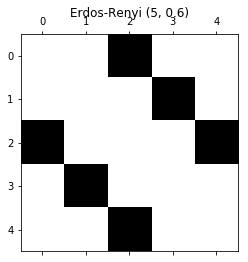

In [6]:
er = erdos_renyi(5, 0.5)
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

In [7]:
er

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

Text(0.5,1.05,'Erdos-Renyi (10, 0.4)')

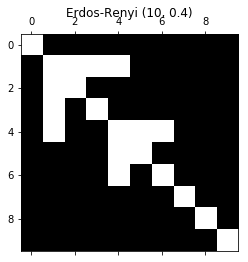

In [8]:
er = erdos_renyi(10, 0.9)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Text(0.5,1.05,'Erdos-Renyi US Senators (n_nodes, p_edge)')

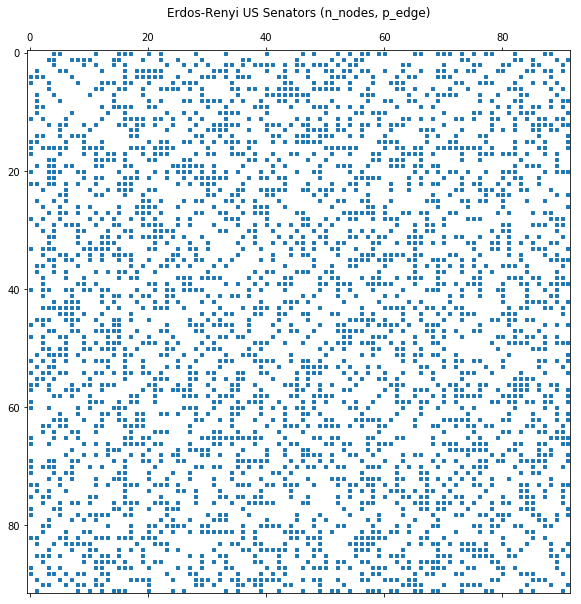

In [9]:
# Your code here.
p_edge  =  n_edges/(n_nodes*(n_nodes-1)/2.0)
erdos_model = erdos_renyi(n_nodes,p_edge)
plt.figure(figsize=(10,10))
plt.spy(erdos_model, markersize=3)
plt.title('Erdos-Renyi US Senators (n_nodes, p_edge)')

In order to be able to compare the graph above to our network,we chose the following parameters for the Erdos-Renyi model:
- We set the  number of nodes to be equal to the number of nodes in our graph
- We set the link probability to be equal to the proportion of edges in our network compared to a fully connected one.


### Question 3

Create a function that constructs a Barabási-Albert graph.

In [131]:
def add_node_and_edges(adjacency, node_nb, m):
    """Add a node to the graph
    
    Parameters
    ----------
    adjacency
        The adjacency matrix of a graph.
    node_nb: int
        node to add
    m: int (optional)
        number of edges that connects the new node to the graph
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    node_degree = np.sum(adjacency[:node_nb],axis = 1)
    total_degrees = np.sum(node_degree)
    nodes_probabilities = node_degree / total_degrees
    new_edges = np.random.choice(node_nb, size=m, p=nodes_probabilities)
    adjacency[node_nb,new_edges] = 1
    adjacency[new_edges,node_nb] = 1

def barabasi_albert(n, m, m0=2, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    assert m<=m0, "invalid Number of edges to attach from a new node to existing nodes, {} {}".format(m,m0)
    np.random.seed(seed=seed)
    
    # Create graph
    adjacency = np.zeros((n,n))
    
    # Add initial edges
    initial_component = np.zeros((m0,m0))
    for i in range(0, m0-1):
        pick = np.random.choice(list(range(i+1, m0)), size=np.random.randint(1, m0 - i))
        initial_component[i,pick] = 1
    initial_component = initial_component + initial_component.T
    
    adjacency[:m0,:m0] = initial_component
    
    # Iterative adding process
    for step in range(m0, n):
        add_node_and_edges(adjacency, step, m)
        
    
    return adjacency


Text(0.5,1.05,'Barabasi-Albert (5, 1)')

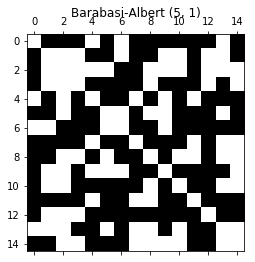

In [132]:
ba = barabasi_albert(15, 10, 10)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

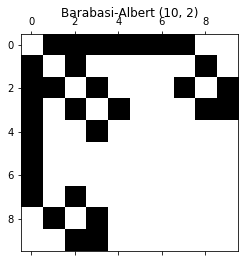

In [12]:
ba = barabasi_albert(10, 2,2)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

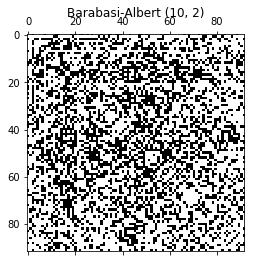

In [27]:
barabasi_model = barabasi_albert(n_nodes, int(np.mean(node_degrees)), int(np.max(node_degrees)))
plt.spy(barabasi_model)
plt.title('Barabasi-Albert (10, 2)')

Since we know that the average degree in a graph generate by the barabase model is $ 2*m $, we  set the number of edges to attach from a new node to existing nodes equal to $ <k> $ where $ <k> $ is the average degree in our network.
Furthermore , we chose to set the $m_0$ parameter to be equal to be our maximum degree since the number of nodes for the inital connected network has to be at least as big as our average degree and that our network has large clustering coefficients.
## Accoding to the formula m should be equal to m/2 but when using this value we get a higher KL-Divergence

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [28]:
n_edges
erdos_renyi_edgecount = np.sum(erdos_model)/2.0
barabasi_edgecount = np.sum(barabasi_model)/2.0

print("The real network has {count} edges.".format(count=n_edges))
print("The Erdős–Rényi model has {count} edges.".format(count=erdos_renyi_edgecount))
print("The Barabási-Albert model has {count} edges.".format(count=barabasi_edgecount))

The real network has 1581.0 edges.
The Erdős–Rényi model has 1557.0 edges.
The Barabási-Albert model has 1656.0 edges.


### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [29]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    mask = np.all([p > 0.0, q > 0.0], axis=0)
    kl = np.sum(np.log(p[mask]/q[mask])*p[mask])
    
    return kl

In [30]:
p_test = np.array([0.2, 0.0, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.0])
kl_divergence(p_test, q_test)

0.057536414490356194

In [31]:
def bin_range_adjust(degrees,binrange,verbose=False):
    ret = binrange.copy()
    dist = np.histogram(degrees, ret,density=False)[0]/len(degrees)
    if verbose:
        print(dist.sum())
    kept_bins = (np.nonzero(dist != 0)[0])
    ret = ret[kept_bins+1] 
    ret = np.insert(ret,0,binrange[0])
    ret[-1] = max(np.max(degrees)+ 1,binrange[-1])

    return ret

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [32]:
binwidth = 2
binrange = np.arange(0, 99 + binwidth, binwidth)

erdos_node_degrees = np.count_nonzero(erdos_model, axis=1)
barabasi_node_degrees = np.count_nonzero(barabasi_model, axis=1)


# Compute distributions
binrange = bin_range_adjust(node_degrees,binrange)
binrange = bin_range_adjust(erdos_node_degrees,binrange)
real_dist = np.histogram(node_degrees, binrange,density=False)[0]/len(node_degrees)
erdos_dist =  np.histogram(erdos_node_degrees, binrange)[0]/len(node_degrees)
print("KL divergence between real network and Erdos model is {divergence}".format(divergence = kl_divergence(real_dist, erdos_dist)))
binrange = np.arange(0, 99 + binwidth, binwidth)
binrange = bin_range_adjust(node_degrees,binrange)
binrange = bin_range_adjust(barabasi_node_degrees,binrange)
real_dist = np.histogram(node_degrees, binrange,density=False)[0]/len(node_degrees)
barabasi_dist = np.histogram(barabasi_node_degrees, binrange)[0]/len(node_degrees)
print("KL divergence between real network and Barabasi model is {divergence}".format(divergence = kl_divergence(real_dist, barabasi_dist)))

assert np.isclose(np.sum(real_dist), 1)
assert np.isclose(np.sum(erdos_dist), 1)
assert np.isclose(np.sum(barabasi_dist), 1)

KL divergence between real network and Erdos model is 0.5141407945555775
KL divergence between real network and Barabasi model is 0.2968110823221159


### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

Text(0.5,1,'Degree distribution of nodes in the Barabàsi-Albert model')

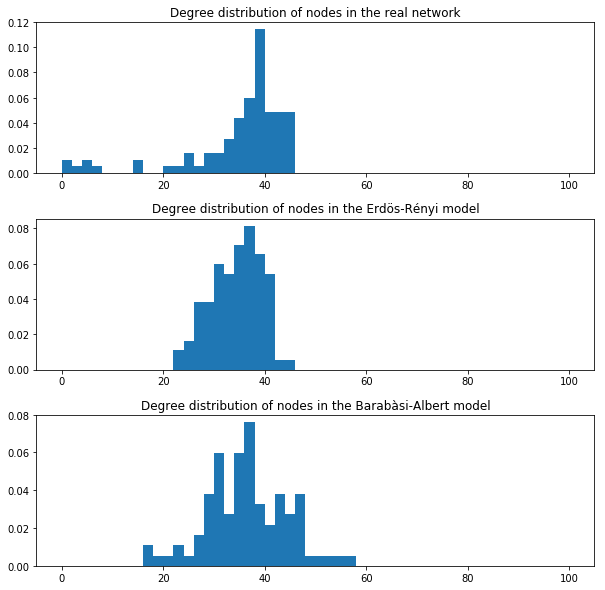

In [33]:
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(3, 1)
f.set_figheight(10)
f.set_figwidth(10)
f.subplots_adjust(hspace=0.3)
binwidth = 2
binrange = np.arange(0, 99 + binwidth, binwidth)
axarr[0].hist(node_degrees, bins=binrange,density=True)
axarr[0].set_title("Degree distribution of nodes in the real network")
axarr[1].hist(erdos_node_degrees, bins=binrange,density=True)
axarr[1].set_title("Degree distribution of nodes in the Erdös-Rényi model")
axarr[2].hist(barabasi_node_degrees, bins=binrange,density=True)
axarr[2].set_title("Degree distribution of nodes in the Barabàsi-Albert model")

### Answer

The resulting histograms are not consistent with the KL-divergences computed above. We can see through the histograms above that our network and the Erdös-Rényi graph are skewed around the same range of values and that that their centers are close to each others.The only major difference between the latter distribution is observed for the left distribution tails as our distribution seems to have a heavier left tail compared to the Erdös-Rényi graph. Mainwhile, the degree distribution of the graph generated by the Barabàsi-Albert model  have a heavier right tail and a center which does not match with our network degree distribution.



### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

### Answer 

No, consider the following simple example:

Suppose you have n nodes, with n being a multiple of 3. Connect those nodes such as to form a circle. Clearly, the degree distribution is exactly 2 for each node. 
Now consider another graph made of n nodes where they are split into n/3 small disconnected "triangle" components. The degree distribution is again exactly two per node but the graph exhibits drastically different structures. Therefore, we cannot conclude that two graphs that have identical degree distributions are the same. 

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

In [35]:
import networkx as nx


In [36]:
G_real=nx.from_numpy_matrix(adjacency)
nx.write_gexf(G_real, "test.gexf")

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

### Answer

Let us begin by exaplaining why we believe both the Erdös-Rényi and Barabasi-Albert model are not adapted to our real network.

#### Erdös-Rényi
The Erdös-Rényi model typically shows low clustering coefficient with a degree distribution that converge in distribution to a Poisson distribution. This is not what we observe in our graph.

#### Barabasi-Albert
The Barabasi-Albert model tries to emulate a scale-free network. That is, a network whose degree distribution follows a power law which has a heavy right tail.However the degree distribution plotted above shows that our degree distribution does not exhibit such properties.Moreover  with a barabasi Barabasi-Albert model, we expect to have a clustering coefficient close to ${ln(N)}^2/N = 0.21 $  and a few highly connected nodes which is not the case for our setup.   

#### Properties of our network
We identified the following key properties of our network:
1. It exhibits a small-world property. That is, its diameter seems to be proportional to the logarithm of the number of nodes. In milestone 1 we computed a diameter of 3 for ~100 nodes.
2. It has a high level of clustering. Indeed, in milestone 1 we computed a coefficient larger than 0.8
3. Even without being too aggressive during the sparsification procedure, we clearly see that the graph is made of two clusters. The cause is immediate if we look at the labels of the vectors used to compute the similarities. Indeed, the two clusters correspond respectively to demotratic and republican senators.

We therefore opt for the *Watts-Strogatz* model which should typically have the small world property and a high clustering coefficient. We will also try a variant of the Watts-Strogatz where we start with two sets of nodes, corresponding to the democratic and republican clusters.

### Question 11

Explain (in short) how the chosen model works.

### Answer 
The model is characterized by three parameters: 

* N, the number of nodes in the network
* K, the average degree 
* p, a rewiring probability

It is built through the following procedure:

1. We start from a ring network where each node is connected to its K closest neighbors. K/2 at its left and K/2 at its right.
2. We iterate over each link and rewire it with probability p. If a link is rewired we chose the new neighbor uniformly at random (we do not allows for self-loops).

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [37]:
def gen_watts_model(N, K, p):
    adjacency = np.zeros((N,N))
    
    # Build the circle lattice
    for i in range(0,N):
        for neighbor in range(int(-K/2), int(K/2 + 1)):
            adjacency[i, np.mod( i + neighbor, N)] = 1
            
    adjacency = adjacency - np.identity(N)

            
    # Rewire each node with probability p
    for i in range(0,N):
        for neighbor in range(1, int(K/2 + 1)):
            if np.random.choice([True, False], size=1, p=(p, 1-p)):
                candidate_neighbors = [x for x in np.where(adjacency[i] == 0)[0] if x != i ]
                new_neighbor = np.random.choice(candidate_neighbors, size=1)
                adjacency[i, np.mod( i + neighbor, N)] = 0
                adjacency[np.mod( i + neighbor, N), i] = 0
                adjacency[i, new_neighbor] = 1
                adjacency[new_neighbor, i] = 1

    assert np.sum(adjacency) == N * K  
    
    return adjacency

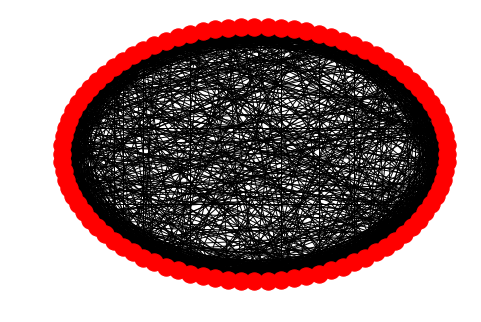

In [38]:
#watts_model = gen_watts_model(50, int(np.mean(node_degrees)), 0.25)
#G=nx.from_numpy_matrix(watts_model)
real_net_degree =  int(np.mean(node_degrees))
G = nx.watts_strogatz_graph(len(node_degrees), real_net_degree, 0.25)
nx.draw_circular(G)

### Question 13

Check the properties you expected to be similar, and compare to your network.

In [39]:
#watts_node_degrees = np.count_nonzero(watts_model, axis=1)
#
## Compute distributions
#watts_dist =  np.histogram(watts_node_degrees, binrange)[0] / len(watts_node_degrees)
#print("KL divergence: {}".format(kl_divergence(real_dist, watts_dist)))

In [54]:

range_it = np.arange(0,1,0.05)
all_components = [x for x in nx.connected_components(G_real)]
sub_graphs = [G_real.subgraph(x) for x in all_components]
real_net_diameters = np.array([nx.diameter(x) for x in sub_graphs])
average_clustering_net_real = nx.average_clustering(G_real) 


In [58]:

def find_best_rewiring(node_degrees,real_net_degree,real_net_avg_diameter,average_clustering_net_real,verbose=True):
    minimum  = 123333
    arg_minimum = 1
    min_dist_average_clustering_coeff = 100000
    best_dist_diameter = 2000
    # Seach for best parameters
    best_net = None
    b_avg_clustering_coeff = None
    best_diameter = None
    for idx,i in enumerate(range_it):

                G = nx.watts_strogatz_graph(len(node_degrees),real_net_degree , i)
                binrange = np.arange(0, 99 + binwidth, binwidth)
                if len(G.degree) == 0:
                    continue
                watts_node_degrees = np.array(G.degree)[:,1]
                # Compute distributions
                binrange = bin_range_adjust(node_degrees,binrange)
                #print(np.nonzero(watts_node_degrees))
                #print(binrange)
                binrange = bin_range_adjust(watts_node_degrees,binrange)
                real_dist = np.histogram(node_degrees, binrange)[0] / len(node_degrees)

                watts_dist = np.histogram(watts_node_degrees, binrange)[0] / len(watts_node_degrees)

                #print(binrange,np.unique(watts_node_degrees),np.unique(node_degrees))
                kl_div = kl_divergence(real_dist, watts_dist)
                watts_network_diameter = nx.diameter(G)
                average_cluster_coeff = nx.average_clustering(G)
                dist = np.abs(average_cluster_coeff-average_clustering_net_real)
                dist_diameter = np.abs(watts_network_diameter - real_net_avg_diameter)
                if (kl_div < minimum) and (arg_minimum <= idx) and dist_diameter < best_dist_diameter and (dist<min_dist_average_clustering_coeff):
                    minimum = kl_div
                    arg_minimum = idx
                    min_dist_average_clustering_coeff = dist
                    b_avg_clustering_coeff = average_cluster_coeff
                    best_net = G
                    best_diameter = watts_network_diameter
                if verbose:
                    print()
                    print('Rewiring probability:',i)
                    print()
                    print('Net diameter:',watts_network_diameter)
                    print('Average clustering coeff:',average_cluster_coeff)
                    print("KL divergence: {}".format(kl_div))
    return minimum,arg_minimum,b_avg_clustering_coeff,best_net,best_diameter


In [59]:
minimum_kl,arg_minimum_1,best_clustering_coeff,G_watts,best_diameter = find_best_rewiring(node_degrees,real_net_degree,3,average_clustering_net_real)



Rewiring probability: 0.0

Net diameter: 3
Average clustering coeff: 0.7272727272727271
KL divergence: 0.0

Rewiring probability: 0.05

Net diameter: 3
Average clustering coeff: 0.6610274926312176
KL divergence: 0.8524821314739034

Rewiring probability: 0.1

Net diameter: 3
Average clustering coeff: 0.5848470444832735
KL divergence: 1.6997352217375663

Rewiring probability: 0.15000000000000002

Net diameter: 3
Average clustering coeff: 0.5464224068347623
KL divergence: 1.187113174816715

Rewiring probability: 0.2

Net diameter: 3
Average clustering coeff: 0.49600247389757873
KL divergence: 1.358288786057026

Rewiring probability: 0.25

Net diameter: 2
Average clustering coeff: 0.46934294928815395
KL divergence: 1.348263560528129

Rewiring probability: 0.30000000000000004

Net diameter: 2
Average clustering coeff: 0.43501916247906847
KL divergence: 1.1553294991752399

Rewiring probability: 0.35000000000000003

Net diameter: 2
Average clustering coeff: 0.41650765561493985
KL divergence:

In [60]:
print('Best KL:',minimum_kl)
print('Best avg clustering coeff:',best_clustering_coeff)
print('Best rewiring probability:',range_it[arg_minimum_1])
print('Best diameter:', best_diameter)

Best KL: 0.8524821314739034
Best avg clustering coeff: 0.6610274926312176
Best rewiring probability: 0.05
Best diameter: 3


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01630435,
        0.04891304, 0.1576087 , 0.13586957, 0.0923913 , 0.03804348,
        0.01086957, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
         26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
         52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
         78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]),
 <a list of 50 Patch objects>

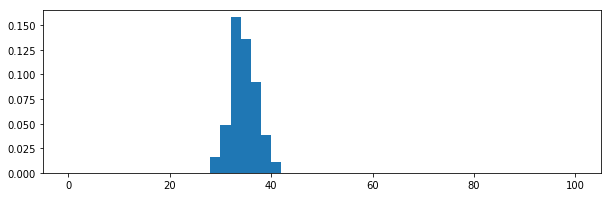

In [61]:
plt.figure(figsize=(10,3))
binwidth = 2
binrange = np.arange(0, 99 + binwidth, binwidth)

watts_node_degrees = np.array(G.degree)[:,1]
plt.hist(watts_node_degrees, bins=binrange,density=True)

In [62]:
# Second graph with two components
all_components = [i for i in nx.connected_components(G_real)]
degrees = [np.array(x.degree)[:,1] for x in sub_graphs]
avg_degrees = [int(x.mean()) for x in degrees]
average_clustering_net_real = [nx.average_clustering(x) for x in sub_graphs]
best_nets = []
for idx,degs in enumerate(degrees):
    minimum_kl,arg_minimum_1,best_clustering_coeff,best_net,best_diameter = find_best_rewiring(degs,avg_degrees[idx],real_net_diameters[idx],average_clustering_net_real[idx],verbose=False)
    print('Best KL:',minimum_kl)
    print('Best avg clustering coeff:',best_clustering_coeff)
    print('Best rewiring probability:',range_it[arg_minimum_1])
    print('Best diameter:', best_diameter)
    print()
    best_nets.append(best_net)

best_graph = nx.union(*(best_nets),rename=('C1','C2'))





Best KL: 1.5067982715977506
Best avg clustering coeff: 0.7101585650396056
Best rewiring probability: 0.05
Best diameter: 2

Best KL: 1.2292938863426233
Best avg clustering coeff: 0.7837695802783742
Best rewiring probability: 0.05
Best diameter: 2



In [71]:
def add_node_and_edges_tweaked(adjacency, node_nb, m,power_preferential_attachement=2.3):
    """Add a node to the graph
    
    Parameters
    ----------
    adjacency
        The adjacency matrix of a graph.
    node_nb: int
        node to add
    m: int (optional)
        number of edges that connects the new node to the graph
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    node_degree = np.sum(adjacency[:node_nb],axis = 1)
    total_degrees = np.sum(node_degree)
    nodes_probabilities = node_degree**(power_preferential_attachement)
    nodes_probabilities = nodes_probabilities/np.sum(nodes_probabilities)
    new_edges = np.random.choice(node_nb, size=m, p=nodes_probabilities)
    adjacency[node_nb,new_edges] = 1
    adjacency[new_edges,node_nb] = 1
def barabasi_albert_tweaked(n, m, m0=2,growth_function=add_node_and_edges_tweaked, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    assert m<=m0, "invalid Number of edges to attach from a new node to existing nodes"
    np.random.seed(seed=seed)
    
    # Create graph
    adjacency = np.zeros((n,n))
    
    # Add initial edges
    initial_component = np.zeros((m0,m0))
    for i in range(0, m0-1):
        pick = np.random.choice(list(range(i+1, m0)), size=np.random.randint(1, m0 - i))
        initial_component[i,pick] = 1
    initial_component = initial_component + initial_component.T
    
    adjacency[:m0,:m0] = initial_component
    
    # Iterative adding process
    for step in range(m0, n):
        growth_function(adjacency, step, m)
        
    
    return adjacency

In [68]:
def log_properties(real_net_degrees,other_dist_degrees,other_graph):
    binwidth = 2
    binrange = np.arange(0, 99 + binwidth, binwidth)
    binrange = bin_range_adjust(real_net_degrees,binrange)

    node_degrees_ = np.array(other_graph.degree)[:,1].astype(int)
    binrange = bin_range_adjust(node_degrees_,binrange)
    real_dist = np.histogram(real_net_degrees, binrange)[0] / len(real_net_degrees)
    
    other_dist = np.histogram(node_degrees_, binrange)[0] / len(node_degrees_)
    #print(binrange,np.unique(watts_node_degrees),np.unique(node_degrees))
    kl_div = kl_divergence(real_dist, other_dist)
    print('Full network KL divergence:',kl_div)
    print('Full network average clustering coefficient:',nx.average_clustering(other_graph))
    print('Full network diameters:',[nx.diameter(nx.subgraph(other_graph,x)) for x in nx.connected_components(other_graph)])
    print('Full network mean degree:',node_degrees_.mean())
    print('Full network degree std:',node_degrees_.std())
    print('Full network min and max degrees:',node_degrees_.min(),node_degrees_.max())

    

In [69]:
log_properties(node_degrees,watts_node_degrees,best_graph)

Full network KL divergence: 1.0071486079866057
Full network average clustering coefficient: 0.7477641923898461
Full network diameters: [2, 2]
Full network mean degree: 33.06521739130435
Full network degree std: 3.1787485499871435
Full network min and max  degrees: 28 38


In [142]:
G_erdos = nx.from_numpy_matrix(erdos_model)
G_barabasi = nx.from_numpy_matrix(barabasi_model)
print('ERDOS')
log_properties(node_degrees,np.array(G_erdos.degree)[:,1],G_erdos)
print()
print('Barabasi')
log_properties(node_degrees,np.array(G_barabasi.degree)[:,1],G_barabasi)
print()
print('Normal wattz strogattz')
log_properties(node_degrees,np.array(G_watts.degree)[:,1],G_watts)
print()

print('2 components wattz strogattz')
log_properties(node_degrees,np.array(best_graph.degree)[:,1],best_graph)
print()

print('Tweaked Barabasi')
G_tweaked_barabasi = nx.from_numpy_matrix(barabasi_albert_tweaked(n_nodes, int(np.mean(node_degrees)), int(np.max(node_degrees)),
                                                                  growth_function=lambda x,y,z:add_node_and_edges_tweaked(x,y,z,power_preferential_attachement=5)))
log_properties(node_degrees,np.array(G_tweaked_barabasi.degree)[:,1],G_tweaked_barabasi)
print()

print('Custom graph')
G_custom = nx.compose(nx.barabasi_albert_graph(len(node_degrees),int(real_net_degree/6)),nx.watts_strogatz_graph(len(node_degrees),int((5*real_net_degree)/6) , 0.1))
log_properties(node_degrees,np.array(G_custom.degree)[:,1],G_custom)
print()

print('2 components barabasi')
G_barabasis = [nx.barabasi_albert_graph(x.number_of_nodes(),int(np.array(x.degree())[:,1].mean())) for x in sub_graphs]
G_barabasis = nx.union(*G_barabasis,rename=['C1','C2'])
log_properties(node_degrees,np.array(G_barabasis.degree)[:,1],G_barabasis)
print()
print('original')
log_properties(node_degrees,node_degrees,G_real)


ERDOS
Full network KL divergence: 0.5141407945555775
Full network average clustering coefficient: 0.3732034559720767
Full network diameters: [2]
Full network mean degree: 33.84782608695652
Full network degree std: 4.86767238056721
Full network min and max  degrees: 23 44

Barabasi
Full network KL divergence: 0.2968110823221159
Full network average clustering coefficient: 0.42263906591626665
Full network diameters: [2]
Full network mean degree: 36.0
Full network degree std: 7.879527683924914
Full network min and max  degrees: 17 56

Normal wattz strogattz
Full network KL divergence: 0.8524821314739034
Full network average clustering coefficient: 0.6610274926312176
Full network diameters: [3]
Full network mean degree: 34.0
Full network degree std: 1.1515584902738285
Full network min and max  degrees: 32 37

2 components wattz strogattz
Full network KL divergence: 1.0071486079866057
Full network average clustering coefficient: 0.7477641923898461
Full network diameters: [2, 2]
Full network

Are the results what you expected? Explain.

The analysis above shows that the wattz-strogatts model tends to have a average clustering coefficient and a mean degree which are close to the ones in our network. The handcrafted two component  wattz-strogatts model is even better since the latter has a hifh